<a href="https://colab.research.google.com/github/StankoDiego/SOA_EA_2/blob/main/HPC/Stanko_Diego_ejercicio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Introducción

#2. Armado del ambiente

##2.1 Armado del ambiente en CPU

No se requiere la ejecucion previa de algun comando

##2.1 Armado del ambiente en GPU

Ir a Entornto de ejecucion -> Cambiar tipo de entorno de ejecucion y seleccionar la opcion GPU

In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 14.3MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621008 sha256=223f974f3a0ec8dc0efea6070beb0ff740df33be4a79180f84f64fdcfa4496af
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=899dd2cca408a68be6d621506d5b92d9a17ee5ed758d65e8be084e62a275af37
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


#3. Desarrollo

##3.1 Desarrollo en CPU

##3.2 Desarrollo en GPU

Imagen del filtro: imagen.jpg -RGB- [Ancho: 512, Alto: 768]
Thread: [ 16 , 19  ], Bloque : [ 32 , 27 ]
Total de Thread: [ 512 , 513  ]  =  262656


TypeError: ignored

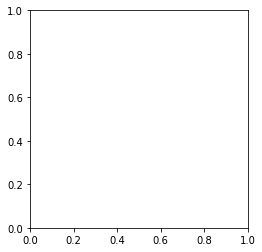

In [ ]:
%matplotlib inline

import time

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

tiempoTotal = (time.time()*1000)

img = 'imagen.jpg'
image = Image.open(img)

img_alto, img_ancho = image.size

img_O_cpu = numpy.asarray(img)
img_R_cpu = numpy.empty_like(img_O_cpu)

img_O_gpu = cuda.mem_alloc(img_O_cpu.nbytes)
img_R_gpu = cuda.mem_alloc(img_R_cpu.nbytes)

cuda.memcpy_htod(img_O_gpu, img_O_cpu)
cuda.memcpy_htod(img_R_gpu, img_R_cpu)

module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, char *img_O, char *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float fGris = 0.0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Calculo el color gris para el pixel a partir de los componentes.
    fGris = (float)img_O[(idx+(idy*ancho))*3    ]*0.299;  // Componente Rojo del pixel.
    fGris +=(float)img_O[((idx+(idy*ancho))*3)+1]*0.599;  // Componente Verde del pixel.
    fGris +=(float)img_O[((idx+(idy*ancho))*3)+2]*0.11;   // Componente Azul del pixel.
    // Escribo el color del pixel.
    img_R[(idx+(idy*ancho))*3  ] = (char) fGris;
    img_R[(idx+(idy*ancho))*3+1] = (char) fGris;
    img_R[(idx+(idy*ancho))*3+2] = (char) fGris;
  }
}
""")

print("Imagen del filtro: " + img + " -" + image.mode + "- [""Ancho: " + str(img_ancho) + ", " + "Alto: " + str(img_alto ) + "]" )

kernel = module.get_function("kernel_img")

tiempo_img = time.time() * 1000

dim_hilo_x = 16
dim_bloque_x = numpy.int((img_ancho + dim_hilo_x - 1) / dim_hilo_x)

dim_hilo_y = 19
dim_bloque_y = numpy.int((img_ancho + dim_hilo_y - 1) / dim_hilo_y)

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = (time.time() *1000)

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = (time.time() *1000) - tiempo_img

cuda.memcpy_dtoh(img_R_cpu, img_R_gpu)

plt.figure()
imgPlot = plt.imshow(img_O_cpu)

plt.figure()
imgPlot = plt.imshow(img_R_cpu)

tiempoTotal = (time.time() * 1000) - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

#4. Tabla de pasos

##4.1 Tabla de pasos CPU

##4.1 Tabla de pasos GPU

#5. Conclusiones